In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpyro

NDEVICES = 16
numpyro.set_host_device_count(NDEVICES)

In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

import pystarboard.data

from cel_utils import disk_utils

In [4]:
token = os.path.join(os.environ['HOME'],'code/auth/spacescope_auth.json')
print(os.path.exists(token))

mcmc_train_len_days = 120
current_date = date(2024, 1, 8)

#current_date = date.today() - timedelta(days=3)
start_date = current_date - timedelta(days=60) # get some historical data
forecast_length = 365*2
end_date = current_date + timedelta(days=forecast_length)
print(start_date, current_date, end_date)

True
2023-11-09 2024-01-08 2026-01-07


In [9]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/cel/filecoin_forecasts/%s/%d' % (current_date.strftime('%Y%m%d'), mcmc_train_len_days))
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [10]:
pystarboard.data.setup_spacescope(token)

In [11]:
@disk_utils.cache_data(directory=offline_info_dir)
def download_simulation_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    return {
        'offline_data': offline_data
    }

x = download_simulation_data()
locals().update(x)

### Run MCMC Forecast of Network Metrics

In [12]:
# MCMC forecasting configuration
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 10000
num_samples_mcmc = 500
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [13]:
def generate_mcmc_forecast_samples(train_start_date: date,
                                   train_end_date: date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose = verbose)
    
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, historical_fpr_date, historical_fpr, deal_onboard_pred_rhats, cc_onboard_pred_rhats = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    diagnostics = {
        'rb_rhats': rb_rhats,
        'ext_rhats': ext_rhats,
        'expire_rhats': expire_rhats,
        'deal_onboard_pred_rhats':deal_onboard_pred_rhats, 
        'cc_onboard_pred_rhats': cc_onboard_pred_rhats
    }
    
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics
    
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose=True)
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'renewal_rate_pred': renewal_rate_pred,
        'filplus_rate_pred': filplus_rate_pred,
        'historical_rb_date': historical_rb_date,
        'historical_rb': historical_rb,
        'historical_rr_date': historical_rr_date,
        'historical_rr': historical_rr,
        'historical_fpr_date': historical_fpr_date,
        'historical_fpr': historical_fpr,
        'diagnostics': diagnostics
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

# print mcmc diagnostics
rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
ext_rhat_check = mcmc.check_rhat(diagnostics['ext_rhats'])
exp_rhat_check = mcmc.check_rhat(diagnostics['expire_rhats'])

print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))
print('Extensions Forecast RHat < 1.05: %0.02f %%' % (ext_rhat_check*100,))
print('Expirations Forecast RHat < 1.05: %0.02f %%' % (exp_rhat_check*100,))

RBP Forecast RHat < 1.05: 100.00 %
Extensions Forecast RHat < 1.05: 96.12 %
Expirations Forecast RHat < 1.05: 96.12 %


In [14]:
def get_quantiles(jax_arr, qvec=[0.25, 0.5, 0.75]):
    return np.quantile(jax_arr, qvec, axis=0)

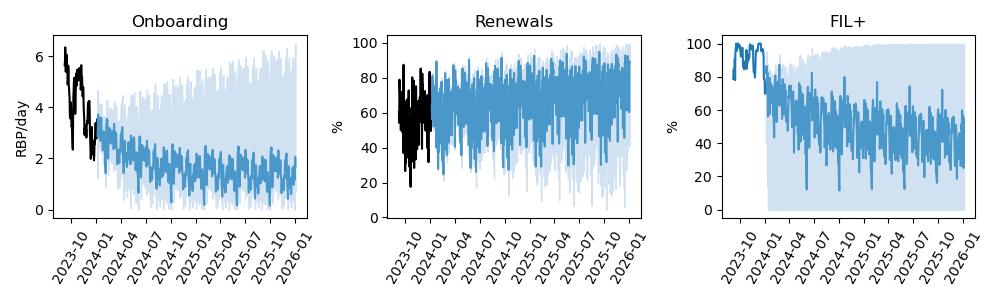

In [15]:
# plot historical trends
t_pred = pd.date_range(historical_rb_date.iloc[-1]+timedelta(days=1), periods=forecast_length, freq='D')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True)

blues = mpl.colormaps['Blues']
axx = ax[0]
axx.plot(historical_rb_date, historical_rb, color='k')
rbp_quantiles = get_quantiles(rb_onboard_power_pred)
axx.plot(t_pred, rbp_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, rbp_quantiles[0], rbp_quantiles[2], color=blues(0.2))
axx.set_title('Onboarding')
axx.set_ylabel('RBP/day')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
axx = ax[1]
axx.plot(historical_rr_date, historical_rr*100, color='k')
rr_quantiles = get_quantiles(renewal_rate_pred*100)
axx.plot(t_pred, rr_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, rr_quantiles[0], rr_quantiles[2], color=blues(0.2))
axx.set_title('Renewals')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[2]
axx.plot(historical_fpr_date, historical_fpr*100)
fpr_quantiles = get_quantiles(filplus_rate_pred*100)
axx.plot(t_pred, fpr_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, fpr_quantiles[0], fpr_quantiles[2], color=blues(0.2))
axx.set_title('FIL+')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.tight_layout()

In [16]:
lock_target = 0.3
sector_duration = 365

simulation_results_vec = []
for ii in tqdm(range(num_samples_mcmc*num_chains_mcmc)):
    rbp_vec = rb_onboard_power_pred[ii,:]
    rr_vec = renewal_rate_pred[ii,:]
    fpr_vec = filplus_rate_pred[ii,:]
    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simulation_results_vec.append(simulation_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
simulation_results.keys()

dict_keys(['1y_return_per_sector', '1y_sector_roi', 'capped_power_EIB', 'circ_supply', 'cum_baseline_reward', 'cum_capped_power_EIB', 'cum_network_reward', 'cum_simple_reward', 'day_locked_pledge', 'day_network_reward', 'day_onboarded_power_QAP_PIB', 'day_pledge_per_QAP', 'day_renewed_pledge', 'day_renewed_power_QAP_PIB', 'day_rewards_per_sector', 'days', 'disbursed_reserve', 'full_renewal_rate', 'network_QAP_EIB', 'network_RBP_EIB', 'network_baseline_EIB', 'network_gas_burn', 'network_locked', 'network_locked_pledge', 'network_locked_reward', 'network_time', 'one_year_vest_saft', 'qa_day_onboarded_power_pib', 'qa_day_renewed_power_pib', 'qa_total_power_eib', 'rb_day_onboarded_power_pib', 'rb_day_renewed_power_pib', 'rb_total_power_eib', 'six_month_vest_saft', 'six_year_vest_foundation', 'six_year_vest_pl', 'six_year_vest_saft', 'three_year_vest_saft', 'total_day_vest', 'total_vest', 'two_year_vest_saft'])

In [18]:
end_date = current_date + timedelta(forecast_length)
macro_t = du.get_t(start_date, end_date=end_date)

In [35]:
def get_simresults_quantiles(sim_results_vec, key, qvec=[0.25, 0.5, 0.75]):
    key_results = []
    for sr in sim_results_vec:
        key_results.append(np.asarray(sr[key]))  # convert jax to np
    
    return np.nanquantile(np.asarray(key_results), qvec, axis=0)

def plot_mcmc_power_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='rb_total_power_eib')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('EiB')
    axx.set_title('RBP')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    axx = ax[1]
    yy = get_simresults_quantiles(simulation_results_vec, key='qa_total_power_eib')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    baseline = get_simresults_quantiles(simulation_results_vec, key='network_baseline_EIB', qvec=[0.5])
    axx.plot(macro_t, baseline[0], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('QAP')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    axx = ax[2]
    yy = get_simresults_quantiles(simulation_results_vec, key='day_network_reward')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    plt.suptitle('Power Metrics')
    plt.tight_layout()

def plot_supply_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='network_locked')
    axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
    axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    axx = ax[1]
    yy = get_simresults_quantiles(simulation_results_vec, key='circ_supply')
    axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
    axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    key_results = []
    for sr in simulation_results_vec:
        key_results.append(np.asarray(sr['network_locked']/sr['circ_supply']))  # convert jax to np
    lcs_q = np.quantile(np.asarray(key_results), [0.25, 0.5, 0.75], axis=0)
    axx = ax[2]
    axx.plot(macro_t, lcs_q[1]*100, color=blues(0.6))
    axx.fill_between(macro_t, lcs_q[0]*100, lcs_q[2]*100, color=blues(0.2))
    axx.set_ylabel('%')
    axx.set_title('L/CS')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    plt.suptitle('Supply Metrics')
    plt.tight_layout()

def plot_onboarding_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='day_pledge_per_QAP')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QA Sector')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    axx = ax[1]
    key_results = []
    for sr in simulation_results_vec:
        key_results.append(np.asarray(sr['1y_sector_roi']*100))  # convert jax to np
    fofr = np.nanquantile(np.asarray(key_results), [0.25, 0.5, 0.75], axis=0)
    axx.plot(macro_t[-len(fofr[0]):], fofr[1], color=blues(0.6))
    axx.fill_between(macro_t[-len(fofr[0]):], fofr[0], fofr[2], color=blues(0.2))
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    plt.suptitle('Onboarding Metrics')
    plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


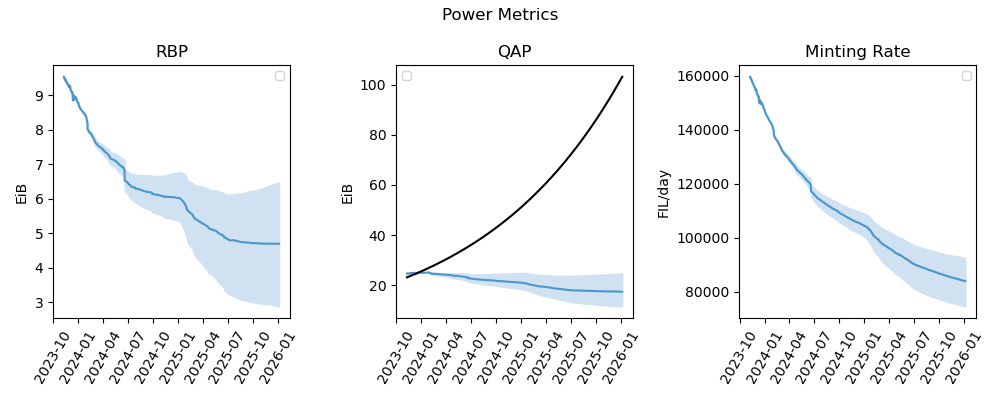

In [32]:
plot_mcmc_power_panel(simulation_results_vec)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


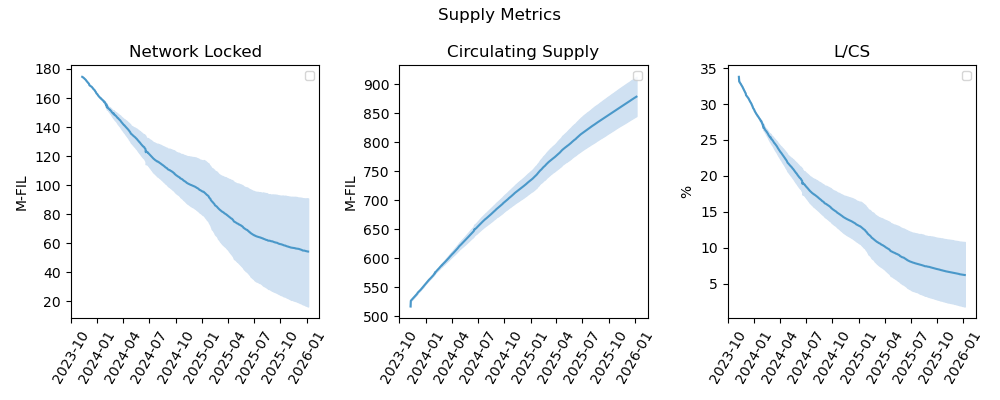

In [33]:
plot_supply_panel(simulation_results_vec)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


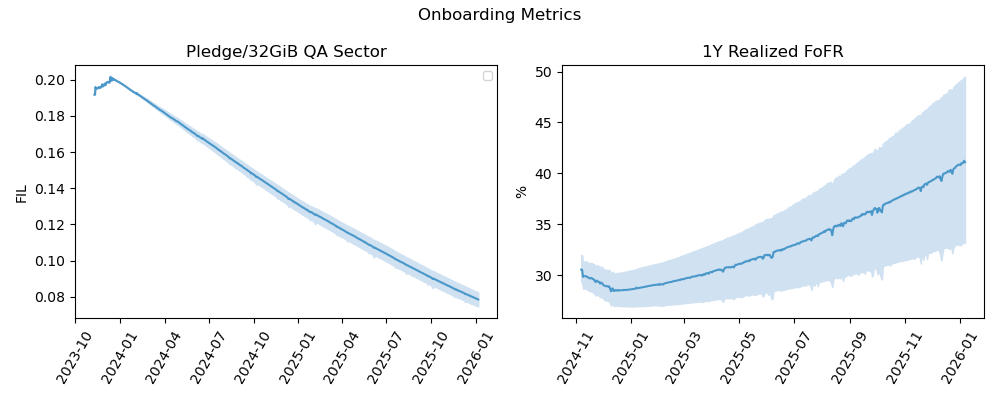

In [36]:
plot_onboarding_panel(simulation_results_vec)

### Run several scenarios scaled from the current Median Rates of RBP, RR, FPR

In [38]:
mcmc_median_rbp = np.median(historical_rb)
mcmc_median_rr = np.median(historical_rr)
mcmc_median_fpr = np.median(historical_fpr)

print(mcmc_median_rbp, mcmc_median_rr, mcmc_median_fpr)

4.17620849609375 0.5846854900127445 0.9543612


In [41]:
rbp_factors = [0.8, 1, 1.2]
rr_factors = [0.8, 1, 1.2]
fpr_factors = [0.8, 1, 1.2]

sim_configs = list(itertools.product(rbp_factors, rr_factors, fpr_factors))
print(sim_configs)

[(0.8, 0.8, 0.8), (0.8, 0.8, 1), (0.8, 0.8, 1.2), (0.8, 1, 0.8), (0.8, 1, 1), (0.8, 1, 1.2), (0.8, 1.2, 0.8), (0.8, 1.2, 1), (0.8, 1.2, 1.2), (1, 0.8, 0.8), (1, 0.8, 1), (1, 0.8, 1.2), (1, 1, 0.8), (1, 1, 1), (1, 1, 1.2), (1, 1.2, 0.8), (1, 1.2, 1), (1, 1.2, 1.2), (1.2, 0.8, 0.8), (1.2, 0.8, 1), (1.2, 0.8, 1.2), (1.2, 1, 0.8), (1.2, 1, 1), (1.2, 1, 1.2), (1.2, 1.2, 0.8), (1.2, 1.2, 1), (1.2, 1.2, 1.2)]


In [ ]:
lock_target = 0.3
sector_duration = 365

simulation_results_vec = []
for ii in tqdm(range(num_samples_mcmc*num_chains_mcmc)):
    rbp_vec = rb_onboard_power_pred[ii,:]
    rr_vec = renewal_rate_pred[ii,:]
    fpr_vec = filplus_rate_pred[ii,:]
    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simulation_results_vec.append(simulation_results)

### Check Various Levels of Onboarding for how fast they catch up to Baseline

In [23]:
lock_target = 0.3
sector_duration = 365
# fix RR & FPR
rr_vec = np.median(renewal_rate_pred, axis=0)
fpr_vec = np.median(filplus_rate_pred, axis=0)
rbp_values = np.linspace(8, 15, 20)
cvec_idx = np.linspace(0.2,0.8,len(rbp_values))

qap_catchup_results = []
for rbp in rbp_values:
    rbp_vec = jnp.ones(forecast_length)*rbp
    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    qap_catchup_results.append(simulation_results)
    

In [27]:
qap_catchup_results[0].keys()

dict_keys(['1y_return_per_sector', '1y_sector_roi', 'capped_power_EIB', 'circ_supply', 'cum_baseline_reward', 'cum_capped_power_EIB', 'cum_network_reward', 'cum_simple_reward', 'day_locked_pledge', 'day_network_reward', 'day_onboarded_power_QAP_PIB', 'day_pledge_per_QAP', 'day_renewed_pledge', 'day_renewed_power_QAP_PIB', 'day_rewards_per_sector', 'days', 'disbursed_reserve', 'full_renewal_rate', 'network_QAP_EIB', 'network_RBP_EIB', 'network_baseline_EIB', 'network_gas_burn', 'network_locked', 'network_locked_pledge', 'network_locked_reward', 'network_time', 'one_year_vest_saft', 'qa_day_onboarded_power_pib', 'qa_day_renewed_power_pib', 'qa_total_power_eib', 'rb_day_onboarded_power_pib', 'rb_day_renewed_power_pib', 'rb_total_power_eib', 'six_month_vest_saft', 'six_year_vest_foundation', 'six_year_vest_pl', 'six_year_vest_saft', 'three_year_vest_saft', 'total_day_vest', 'total_vest', 'two_year_vest_saft'])

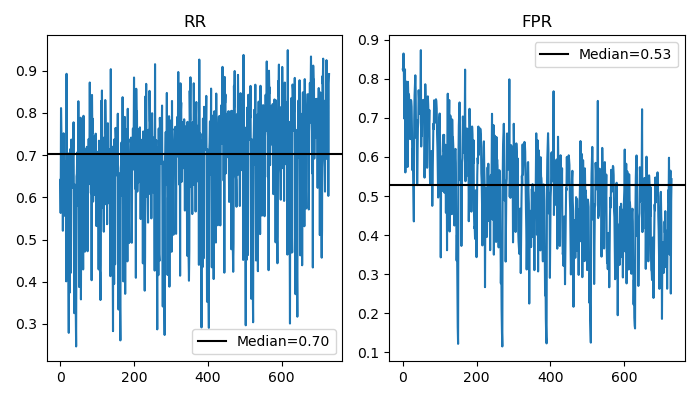

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4))

axx = ax[0]
axx.plot(rr_vec)
mv = np.median(rr_vec)
axx.axhline(mv, color='k', label='Median=%0.02f' % mv)
axx.legend()
axx.set_title('RR')

axx = ax[1]
axx.plot(fpr_vec)
mv = np.median(fpr_vec)
axx.axhline(mv, color='k', label='Median=%0.02f' % mv)
axx.legend()
axx.set_title('FPR')

plt.tight_layout()

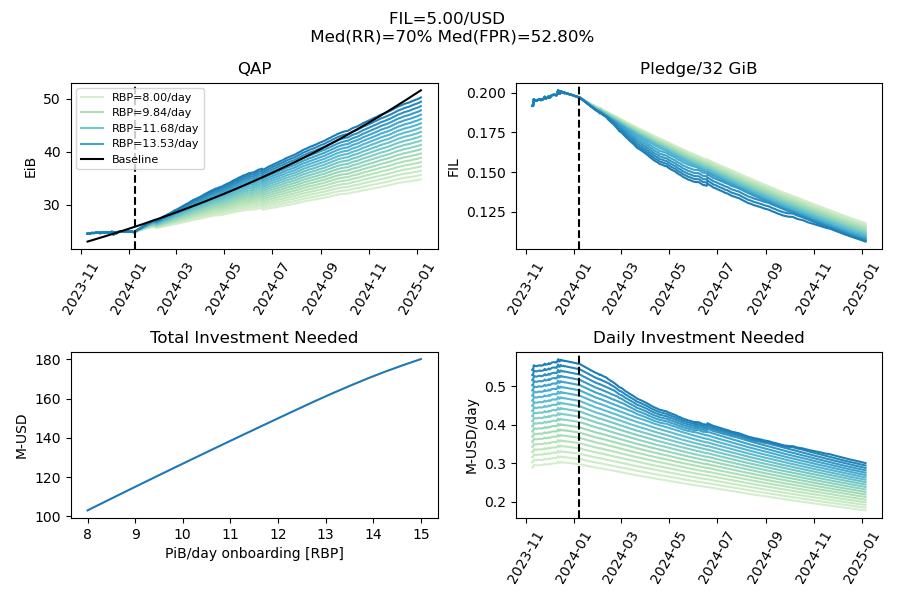

In [25]:
# plot the macro-economic panel
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,6))

cm = mpl.colormaps['GnBu']
axx = ax[0,0]
for ii, rbp in enumerate(rbp_values):
    if ii % 5 == 0:
        l = 'RBP=%0.02f/day' % (rbp,)
    else:
        l = None
    axx.plot(macro_t[:-365], qap_catchup_results[ii]['qa_total_power_eib'][:-365], color=cm(cvec_idx[ii]), label=l)
axx.plot(macro_t[:-365], qap_catchup_results[0]['network_baseline_EIB'][:-365], color='k', label='Baseline')
axx.set_ylabel('EiB')
axx.axvline(current_date, linestyle='--', color='k')
axx.set_title('QAP')
axx.legend(fontsize=8)
for tick in axx.get_xticklabels(): tick.set_rotation(60)

cm = mpl.colormaps['GnBu']
axx = ax[0,1]
for ii, rbp in enumerate(rbp_values):
    if ii % 5 == 0:
        l = 'RBP=%0.02f/day' % (rbp,)
    else:
        l = None
    axx.plot(macro_t[:-365], qap_catchup_results[ii]['day_pledge_per_QAP'][:-365], color=cm(cvec_idx[ii]), label=l)
axx.set_ylabel('FIL')
axx.set_title('Pledge/32 GiB')
# axx.legend(fontsize=8)
axx.axvline(current_date, linestyle='--', color='k')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

FIL_price = 5.00
sector32GiBToPiB = 32 * 1.0/(1024**2)
cm = mpl.colormaps['GnBu']
axx = ax[1,1]
total_investment_needed = []
for ii, rbp in enumerate(rbp_values):
    if ii % 5 == 0:
        l = 'RBP=%0.02f/day' % (rbp,)
    else:
        l = None
    y_val_musd_qa = qap_catchup_results[ii]['day_pledge_per_QAP'][:-365]*rbp*10*np.median(fpr_vec)/sector32GiBToPiB/1e6
    y_val_musd_rb = qap_catchup_results[ii]['day_pledge_per_QAP'][:-365]*rbp*(1-np.median(fpr_vec))/sector32GiBToPiB/1e6
    y_val_musd = y_val_musd_qa + y_val_musd_rb
    axx.plot(macro_t[:-365], y_val_musd, color=cm(cvec_idx[ii]), label=l)
    total_investment_needed.append(np.sum(y_val_musd))
axx.set_ylabel('M-USD/day')
axx.set_title('Daily Investment Needed')
# axx.legend(fontsize=8)
axx.axvline(current_date, linestyle='--', color='k')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[1,0]
axx.plot(rbp_values, total_investment_needed)
axx.set_ylabel('M-USD')
axx.set_title('Total Investment Needed')
axx.set_xlabel('PiB/day onboarding [RBP]')

plt.suptitle('FIL=%0.02f/USD \n Med(RR)=%0.0f%% Med(FPR)=%0.02f%%' % (FIL_price, np.median(rr_vec)*100, np.median(fpr_vec)*100))
plt.tight_layout()